**First we upload dataset**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'



In [ ]:
! pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download koryakinp/chess-positions

100% 3.99G/4.01G [00:42<00:00, 92.7MB/s]
100% 4.01G/4.01G [00:42<00:00, 101MB/s] 


In [ ]:
! unzip chess-positions.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/b1K5-6rB-5k2-5r2-1b6-8-5n2-8.jpeg  
  inflating: train/b1K5-8-3k4-3p4-8-3B1r2-1b6-4N3.jpeg  
  inflating: train/b1K5-8-8-2p3p1-5k2-8-8-7R.jpeg  
  inflating: train/b1K5-8-8-8-2qr1N2-8-6nk-3b4.jpeg  
  inflating: train/b1K5-r7-4kb2-R4Q1p-b7-1pb5-5P2-8.jpeg  
  inflating: train/b1KB4-2B5-3p4-1BB5-3k1n2-p1r5-2n5-5r1q.jpeg  
  inflating: train/b1Kb4-6P1-n2Q3k-8-4N1n1-2b2P2-8-8.jpeg  
  inflating: train/b1Kr4-8-q7-8-1bB5-8-2k1P1RR-8.jpeg  
  inflating: train/b1Kr4-P7-R2R4-1b3B2-3Pr3-4Nk2-8-4R3.jpeg  
  inflating: train/b1N1k3-K1q5-1P1B4-2R5-3N3Q-3brP2-8-1B1n4.jpeg  
  inflating: train/b1N1n1q1-R5RQ-1N2r2P-3n4-3k4-8-3n3N-K7.jpeg  
  inflating: train/b1N1qn2-1P5k-b3K1p1-8-2B4n-7N-5B2-1b2B3.jpeg  
  inflating: train/b1N1r1k1-2R5-1r2b3-5KpR-N1P5-8-6R1-7B.jpeg  
  inflating: train/b1N1r3-2P1r1k1-3b4-8-3K3b-2rB4-7p-8.jpeg  
  inflating: train/b1N2K1b-2Bp4-4B2k-b2p4-8-7n-3p3n-2B2B2.jpeg  
  inflating: train/b1N2b1R-3n4-P2P4-1n2K

**Importing Libraries**

In [ ]:
import re
import cv2
import glob
import random as rd
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")      
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
%matplotlib inline

**1- Exploratory Data Analysis for data quality review**

In [ ]:
#Define train path and test path
train_path = glob.glob("../content/dataset/train/*.jpeg")
test_path = glob.glob("../content/dataset/test/*.jpeg")

#Shuffle train and test samples
rd.shuffle(train_path)
rd.shuffle(test_path)

#Decide the number of train and test samples
train_size =20000
test_size = 4000
train = train_path[:train_size]
test= test_path[:test_size]

# Piece_type = ['King','Queen','Rook','Bishop','Knight','Pawn']|
# Capital = White, Normal = Black
piece_symbols = 'prbnkqPRBNKQ'

♠ Define a function to extract labels/FEN from Images

> Indented block




In [ ]:
# Get the labels ( FNE ) for the training and testing images 
def get_image_FEN_label(image_path):
    fen_label= image_path.replace('.jpeg', '').split('/')[-1]
    return fen_label

♠ Display a random sample of the data


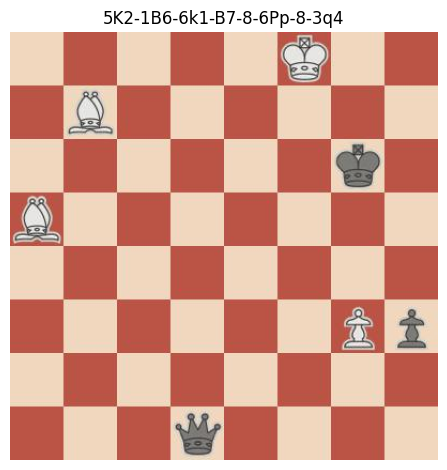

In [ ]:
rand = np.random.randint(0, train_size)
img_path =train[rand]
img_moves =  get_image_FEN_label(img_path)
img_rand=cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_rand, cv2.COLOR_BGR2RGB))
plt.title(img_moves)
plt.axis('off')
plt.tight_layout()
plt.show()

♠ Check the Python Chess Library to understand the FEN format


In [ ]:
! pip install python-chess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 14.8 MB/s eta 0:00:00


The FEN notation of the image is:  5K2-1B6-6k1-B7-8-6Pp-8-3q4


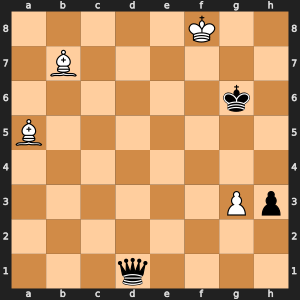

In [ ]:
import chess.svg
import chess
from IPython.display import SVG, display
print("The FEN notation of the image is: ", img_moves)
board = chess.Board(img_moves.replace('-', '/'))
svg_data = chess.svg.board(board, size=300)
display(SVG(svg_data))

**Display a bunch of samples of the data**

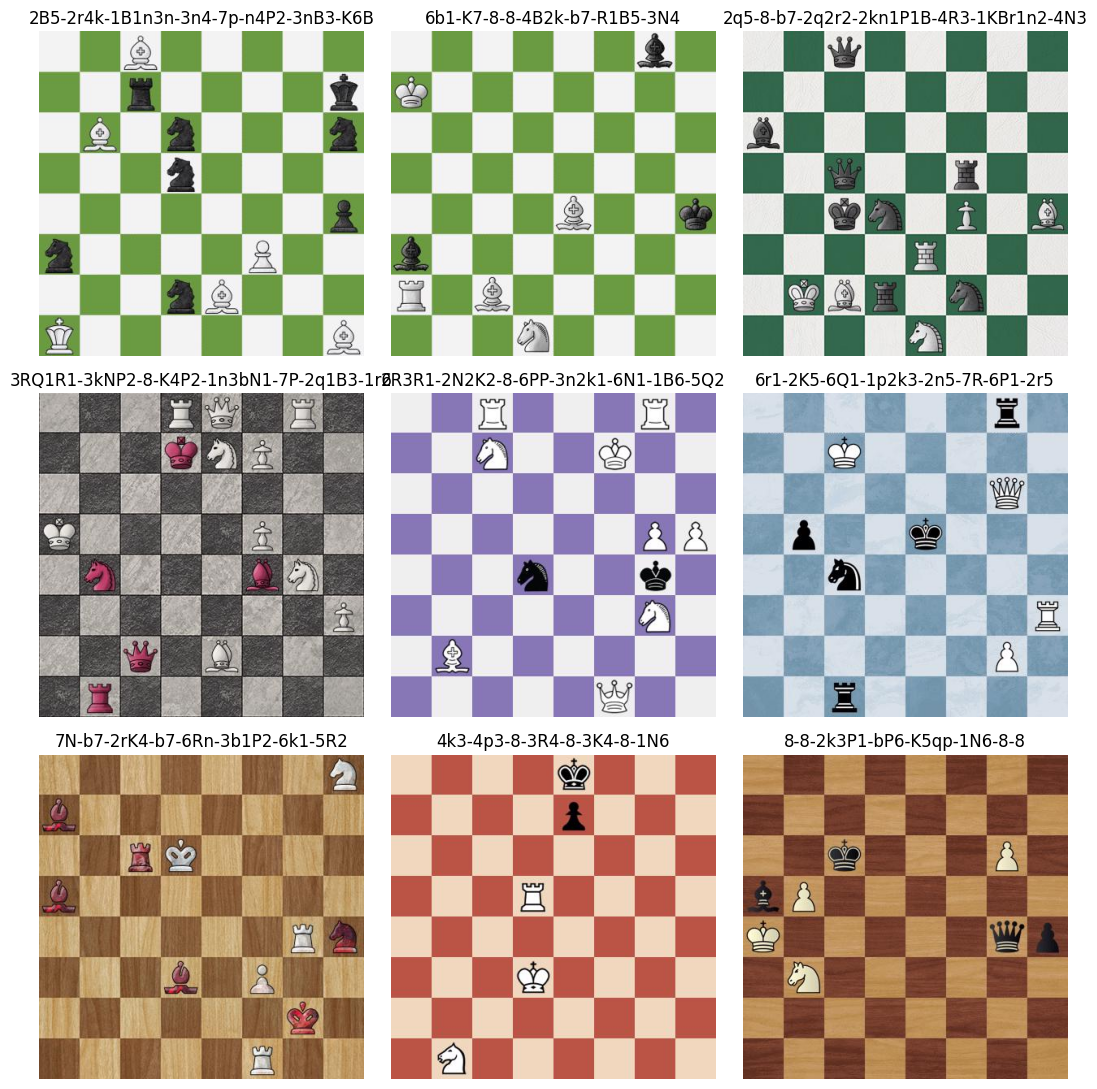

In [ ]:
samples =rd.sample(train, 9)
fig = plt.figure(figsize=(11, 11))
columns = 3
rows = 3
for i, img in zip(range(1, columns*rows +1),samples ):
    fig.add_subplot(rows, columns, i)
    img_moves =  get_image_FEN_label(img)
    img = cv2.imread(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(img_moves)
    plt.tight_layout()
    
plt.show()

**Labels distribution - All labels are Unique**

In [ ]:
labels = [get_image_FEN_label(img) for img in train]
set_labels = set(labels)
print("Number of labels {} is equal to number of images {}".format(len(set_labels), len(train)))


Number of labels 20000 is equal to number of images 20000


Analyzing pictures dimensions and ratio - **Same Ratio, Width, Height for all pictures***

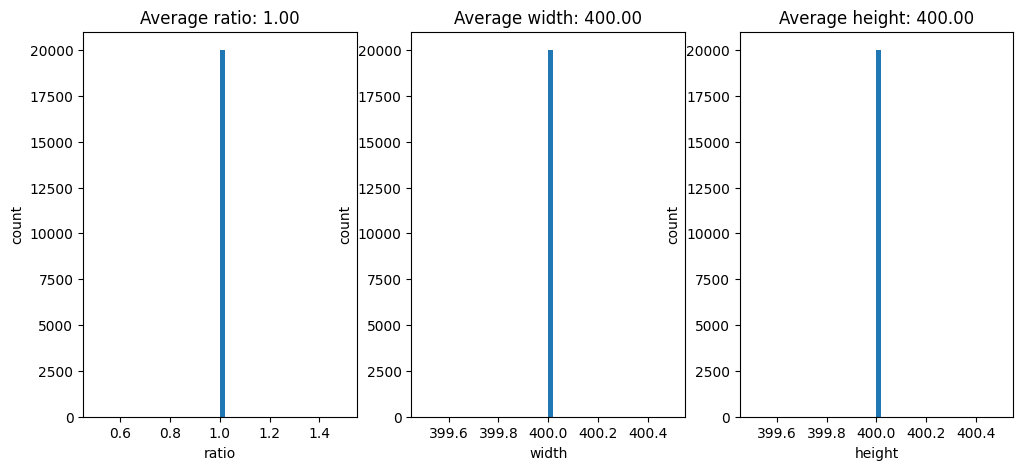

Selected dimensions: 400x400


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

ratios = []
widths = []
heights = []

for img_path in train:
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    ratios.append(width / height)  
    heights.append(height)
    widths.append(width)

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].hist(ratios, bins=50)
axs[0].set_xlabel('ratio')
axs[0].set_ylabel('count')
axs[0].set_title('Average ratio: {:.2f}'.format(np.mean(ratios)))

axs[1].hist(widths, bins=50)
axs[1].set_xlabel('width')
axs[1].set_ylabel('count')
axs[1].set_title('Average width: {:.2f}'.format(np.mean(widths)))

axs[2].hist(heights, bins=50)
axs[2].set_xlabel('height')
axs[2].set_ylabel('count')
axs[2].set_title('Average height: {:.2f}'.format(np.mean(heights)))

plt.show()

print("Selected dimensions: {}x{}".format(int(np.mean(widths)), int(np.mean(heights))))


**2 - Data Preprocessing**

2.B - Resizing, Scaling, Normalization, etc

♠Create a function to Greyscale,Resize and Normalize the data





In [ ]:
def preprocess_some_images(img_paths, width, height):
  resized_imgs = []
  for img_path in img_paths:
    # change to Grey scal
    # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)
  
    # resize the image to the desired size
    gray_image = cv2.resize(img, (width, height))
    
    # Normalize the image
    gray_image =(gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))

    # add to the list
    resized_imgs.append(gray_image)
    
  return resized_imgs

In [ ]:
preprocessed_imgs= preprocess_some_images(samples,240,240)


**Display new image HxW dimensions**

In [ ]:
"{}X{}".format(preprocessed_imgs[0].shape[0],preprocessed_imgs[0].shape[1])

'240X240'

**Display new image shape**

In [ ]:
preprocessed_imgs[0].shape


(240, 240, 3)

 Data Diplay - **Greyscale, Resized and Normalized**

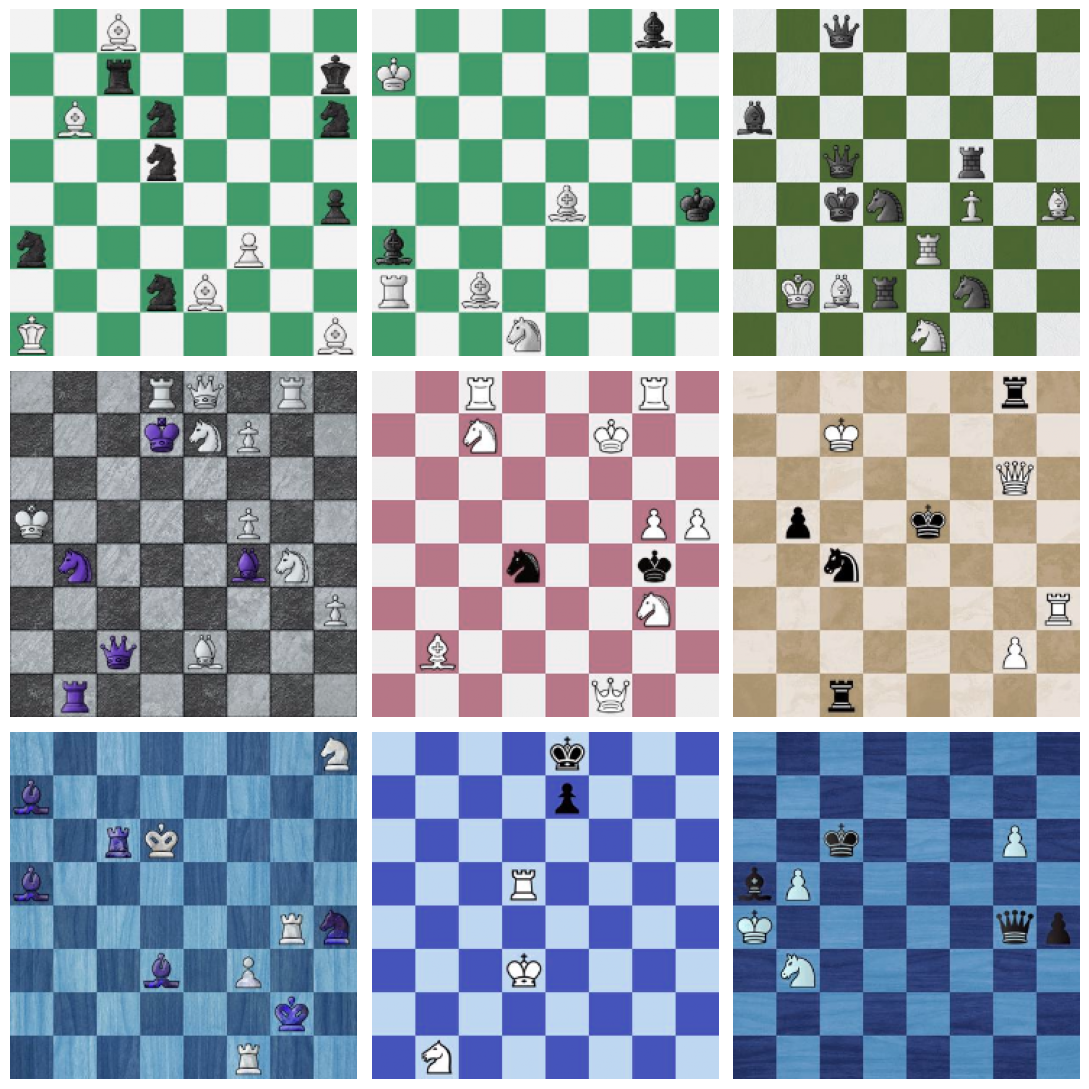

In [ ]:
fig = plt.figure(figsize=(11, 11))
columns = 3
rows = 3
for i, img in zip(range(1, columns*rows +1), preprocessed_imgs):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()

**2.B - PCA Analysis**

1 On the Complete Chess Board

♠ Prepare Image Data for PCA Analysis


(720, 720)

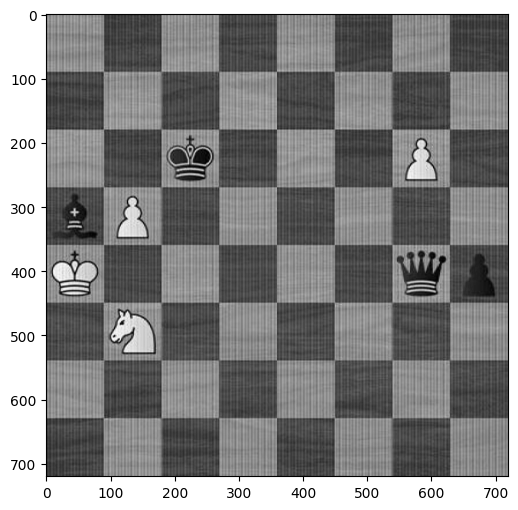

In [ ]:
# Read the image and reshape it
img = cv2.imread(samples[8])
new_img=img.reshape(img.shape[0], (img.shape[1]*img.shape[2]))

# Resize the image
new_img = cv2.resize(new_img, (720, 720), interpolation=cv2.INTER_CUBIC)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(new_img, cmap='gray')
new_img.shape


♠ PCA Analysis - **Components Analysis**


Using 15 components reservers 95.19999999999999% of the features


Text(0, 0.5, 'Cumulative_explained_variance')

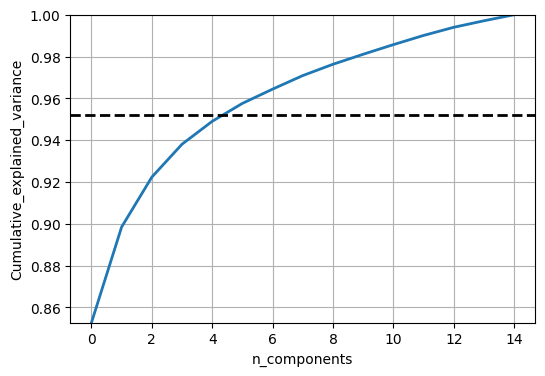

In [ ]:
#Import required modules
from sklearn.decomposition import PCA

pca = PCA()
pca.n_components = 15
img_transformed = pca.fit_transform(new_img)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)
reserved =np.round(np.sum(pca.explained_variance_ratio_),3)*100

print("Using {} components reservers {}% of the features".format(pca.n_components,reserved))

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylim(min(cum_var_explained),1)
plt.axhline(y=reserved/100.0, linestyle='--', color='k', linewidth=2)
plt.ylabel('Cumulative_explained_variance')



♠ PCA Analysis - **Results**


Text(0.5, 1.0, 'After PCA image')

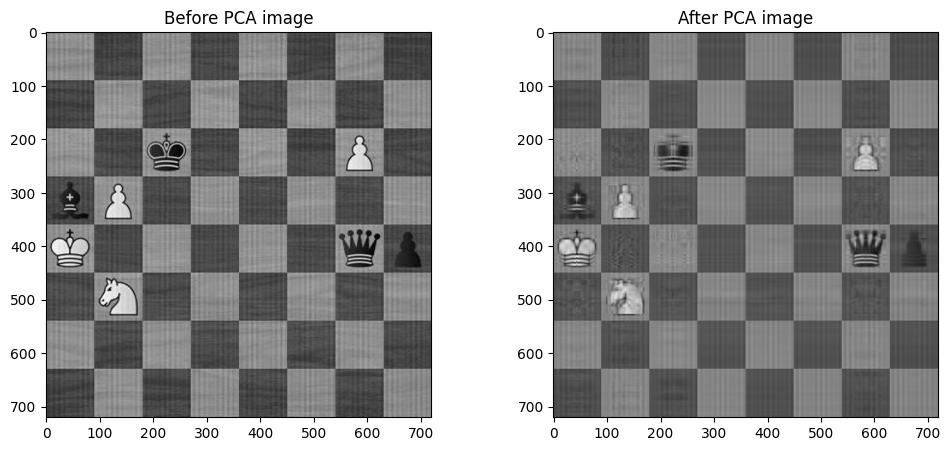

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Load the image and reshape it
img = np.array(cv2.imread(samples[8]))
new_shape = (img.shape[0], img.shape[1] * img.shape[2])
new_img = img.reshape(new_shape)

# Resize the image using cubic interpolation
new_img = cv2.resize(new_img, (720, 720), interpolation=cv2.INTER_CUBIC)

# Show the original image on the first subplot
ax1.imshow(new_img, cmap='gray')
ax1.set_title("Before PCA image")

# Apply PCA and inverse transform to get the reconstructed image
img_transformed = pca.transform(new_img)
reconstructed_img = pca.inverse_transform(img_transformed)
reconstructed_img = np.reshape(reconstructed_img, (720, 720))

# Show the reconstructed image on the second subplot
ax2.imshow(reconstructed_img, cmap='gray')
ax2.set_title("After PCA image")


 2 . On the Chess Board Pieces

 ♠ Prepare Image Data for PCA Analysis




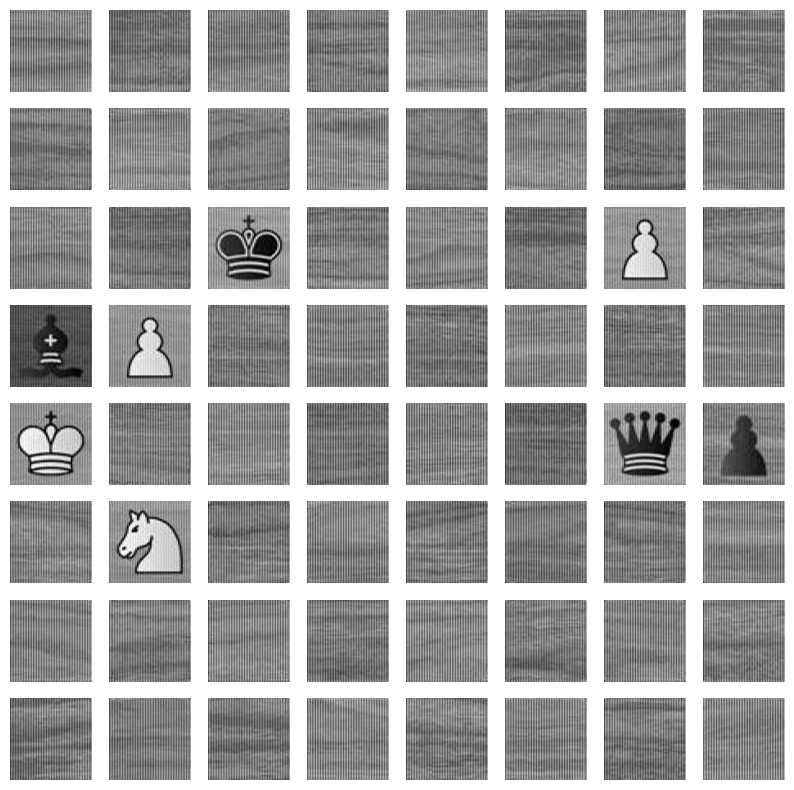

(64, 720, 720)


In [ ]:
def image_to_squares_pca(img, heights, widths):
    # Initialize an empty list to store the squares
    squares = []
    # Loop through each row of the 8x8 grid
    for i in range(8):
        # Loop through each column of the 8x8 grid
        for j in range(8):
            # Extract the square from the image based on the current row and column
            new_img = img[i*heights//8 : i*heights//8+heights//8, j*widths//8 : j*widths//8+widths//8]
            # Reshape the square to be a 1D array
            new_img = new_img.reshape(new_img.shape[0], new_img.shape[1]*new_img.shape[2])
            # Resize the square to 720x720 using cubic interpolation
            new_img = cv2.resize(new_img, (720, 720), interpolation=cv2.INTER_CUBIC)
            # Add the square to the list of squares
            squares.append(new_img)
    # Convert the list of squares to a numpy array and return it
    return np.array(squares)

# Load an image from the samples list
img = np.array(cv2.imread(samples[8]))
# Call the image_to_squares_pca function to extract the 64 squares from the image
squares = image_to_squares_pca(img, 400, 400)
# Create a figure with an 8x8 grid of subplots
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
# Loop through each square and plot it in a subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(squares[i], cmap='gray')
    ax.axis('off')
# Show the plot and print the shape of the squares array
plt.show()
print(squares.shape)


♠ PCA Analysis - **Components Analysis**

Using 5 components reserves 82.39999999999999% of the features


Text(0, 0.5, 'Cumulative_explained_variance')

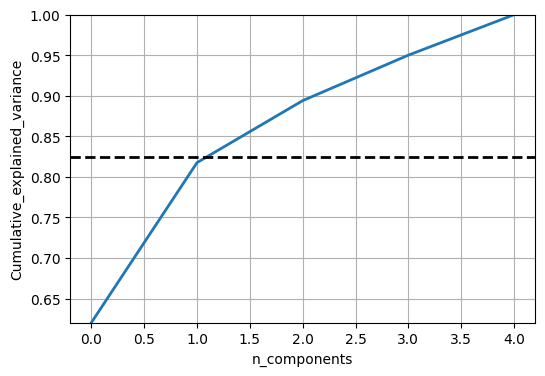

In [ ]:
# Import required modules
from sklearn.decomposition import PCA

# Select a test sample from squares
test_sample = squares[3]

# Initialize PCA object and set number of components to 5
pca = PCA()
pca.n_components = 5

# Fit and transform the test sample with PCA
img_transformed = pca.fit_transform(test_sample)

# Calculate the percentage of variance explained by each component
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

# Calculate the cumulative variance explained by each component
cum_var_explained = np.cumsum(percentage_var_explained)

# Calculate the percentage of features reserved using the selected number of components
reserved = np.round(np.sum(pca.explained_variance_ratio_), 3) * 100

# Print the number of components and percentage of features reserved
print("Using {} components reserves {}% of the features".format(pca.n_components, reserved))

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylim(min(cum_var_explained), 1)
plt.axhline(y=reserved / 100.0, linestyle='--', color='k', linewidth=2)
plt.ylabel('Cumulative_explained_variance')


♠ PCA Analysis - **Results**

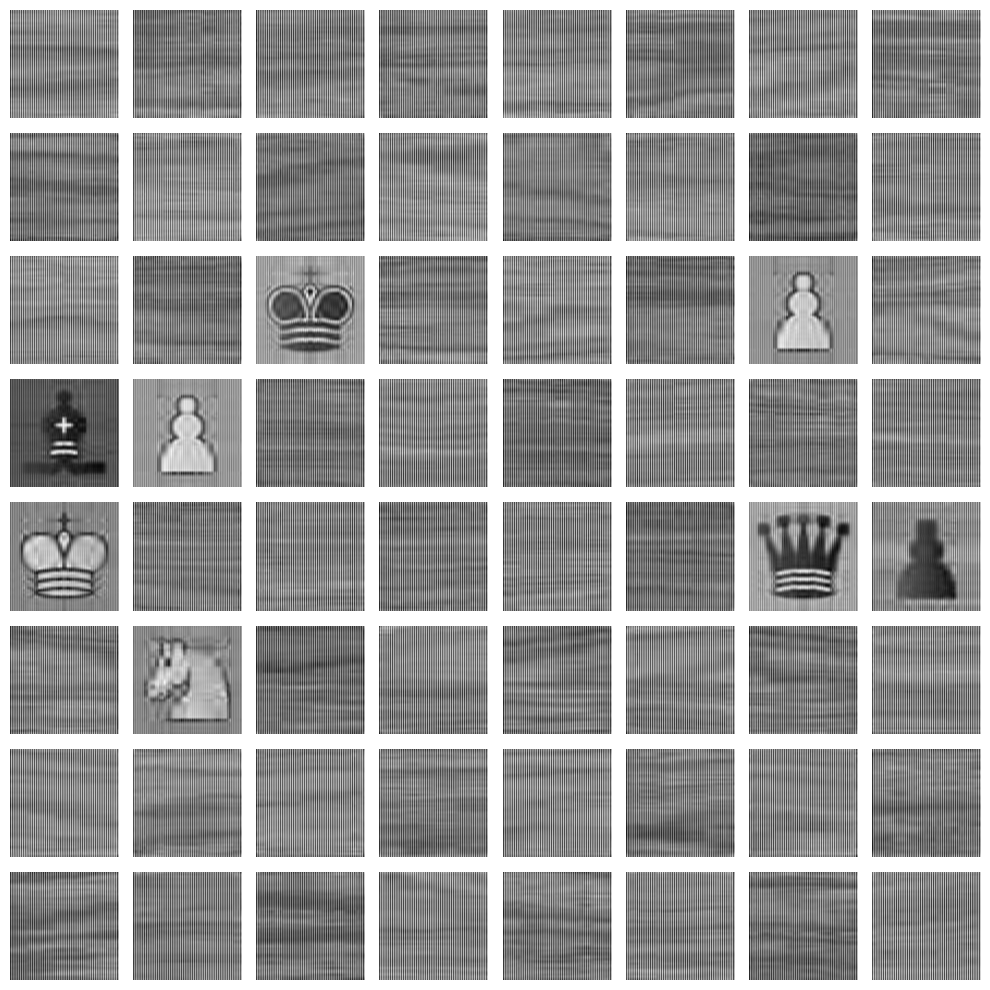

In [ ]:
# Import required modules
from sklearn.decomposition import PCA

# Initialize an empty list to store the PCA transformed squares
squares_PCA = []

# Loop over each square in the original squares list
for img in squares:
    # Initialize a new PCA object
    pca = PCA()
    pca.n_components = 5
    
    # Fit and transform the current square using PCA
    img_transformed = pca.fit_transform(img)
    
    # Inverse transform the transformed image to get the original shape
    temp = pca.inverse_transform(img_transformed) 
    temp = np.reshape(temp, (720,720)) 
    
    # Append the transformed image to the squares_PCA list
    squares_PCA.append(temp)
    
# Plot the transformed squares
fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1),squares_PCA):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()


**3 - Feature Engineering**

In [ ]:
def image_to_squares(img, heights, widths):
    squares = np.array([img[i*heights//8:i*heights//8+heights//8, j*widths//8:j*widths//8+widths//8] 
                        for i in range(8) for j in range(8)])
    return squares


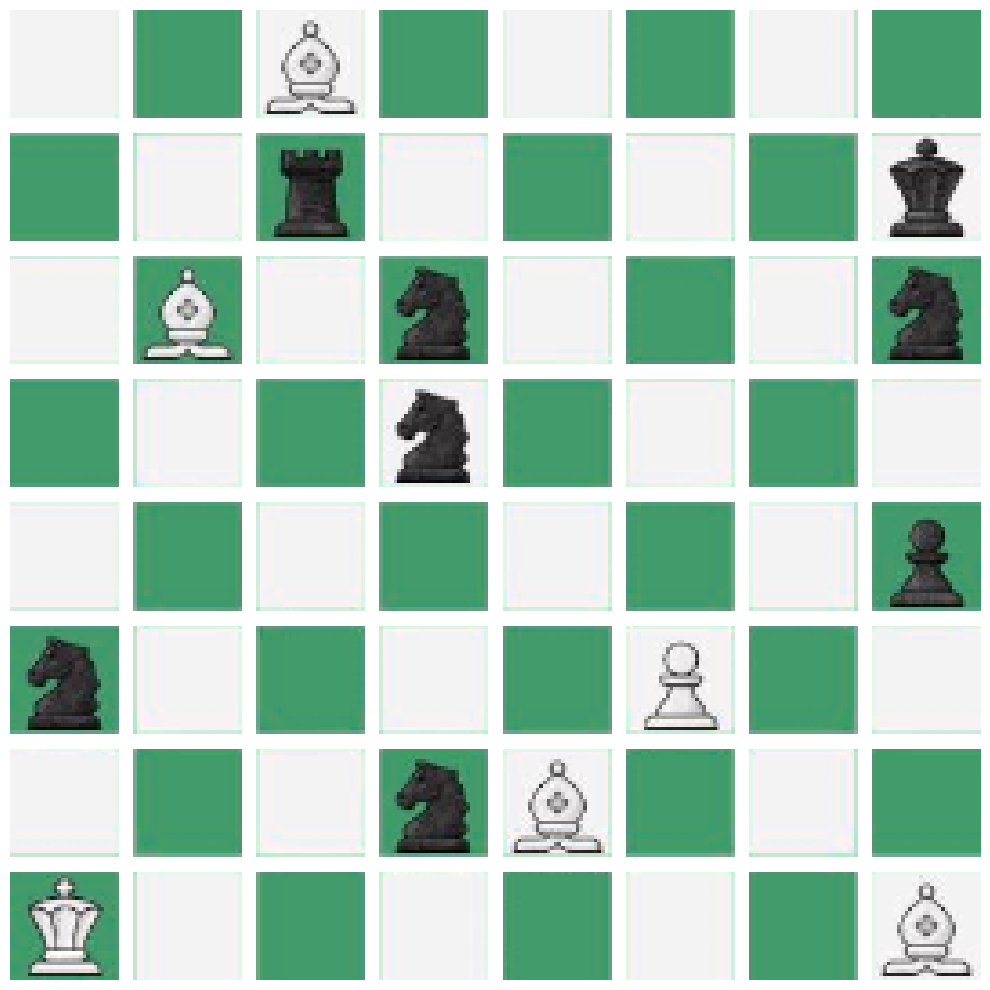

(64, 30, 30, 3)


In [ ]:
# Define a function to create squares
def create_squares(img, height, width):
    squares = []
    for i in range(0,8):
        for j in range(0,8):
            squares.append(img[i*height//8:i*height//8+height//8, j*width//8:j*width//8+width//8])
    return np.array(squares)

# Create squares from preprocessed_imgs[0]
squares = create_squares(preprocessed_imgs[0], 240, 240)

# Display the squares in a grid
fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1), squares):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()

# Print the shape of squares
print(squares.shape)


♠ Create a function to the complete preprocessing and sqaures division of one sample of the data

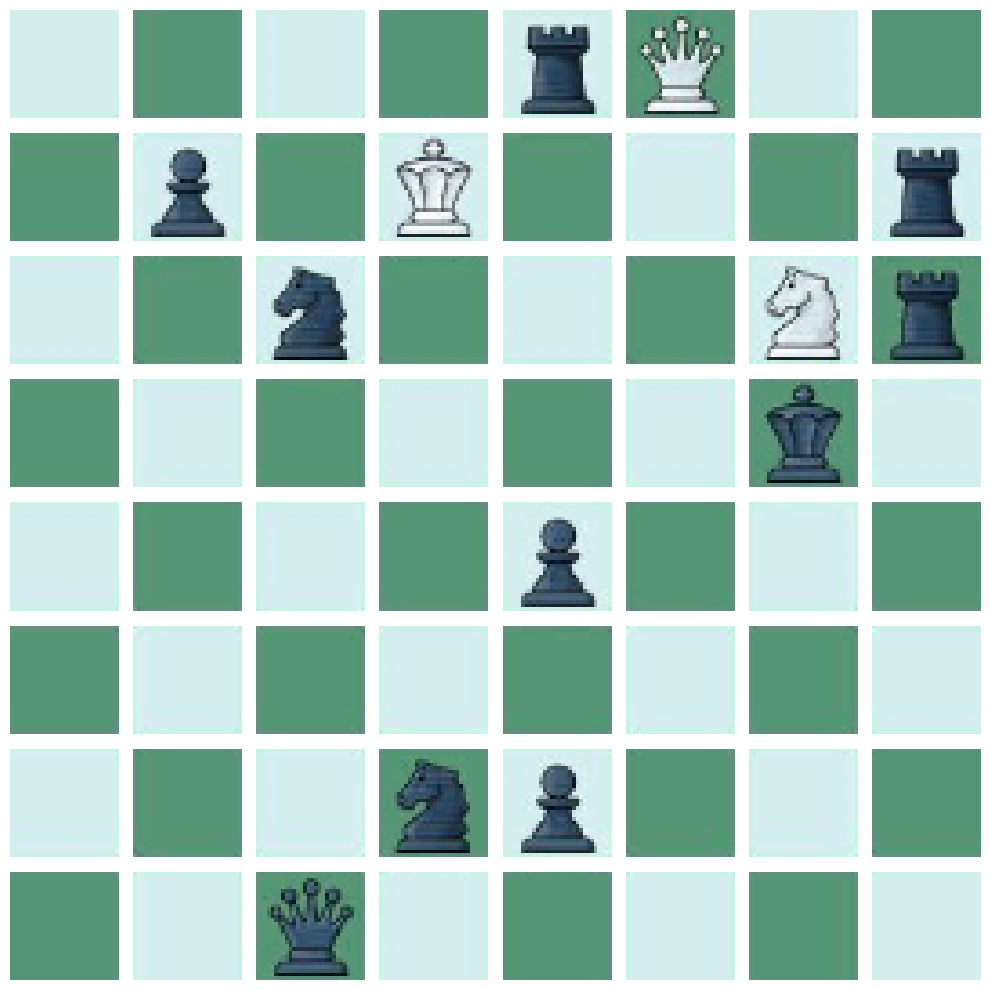

(64, 30, 30, 3)


In [ ]:
# Define a function to preprocess an image and convert it into squares
def preprocess_image(img_path):
    # Set desired height and width for the image
    height = 240
    width = 240
    
    # Read the image in BGR format
    img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)
  
    # Resize the image to the desired size
    gray_image = cv2.resize(img, (width, height))
    
    # Normalize the pixel values to be between 0 and 1
    gray_image = (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))

    # Convert the image into squares
    squares = image_to_squares(gray_image, height, width)
    
    return squares

# Preprocess a sample image
squares = preprocess_image(train[444])

# Plot the squares
fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1), squares):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()

# Print the shape of the squares array
print(squares.shape)


♠ Create a FEN Label Encode /Decoder Functions


In [ ]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

In [ ]:
def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

♠ **Create a function divide the data into training and testing sets**

In [ ]:
def train_gen(features):
    for i, img in enumerate(features):
        y = onehot_from_fen(get_image_FEN_label(img))
        x = preprocess_image(img)
        yield x, y

def pred_gen(features):
    for i, img in enumerate(features):
        y = onehot_from_fen(get_image_FEN_label(img))
        x = preprocess_image(img)
        yield x, y

**4 - Modeling & Model Training**

In [ ]:
# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# Add a convolutional layer
model = Sequential()
model.add(Convolution2D(32, (3, 3),activation='relu', input_shape=(30, 30, 3)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Convolution2D(16, (5, 5),activation='relu'))
model.add(Flatten())
model.add(Dropout(0.35))
model.add(Dense(13, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 9, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 16)          12816     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 13)                5213      
                                                        

In [ ]:
# Compile the model 
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# Fit parameters
EPOCHS=100

print("\nTraining Progress:\n------------------------")
hist = model.fit_generator(train_gen(train), steps_per_epoch=train_size//EPOCHS, epochs=EPOCHS,
                           validation_data=pred_gen(test), validation_steps=test_size//EPOCHS)


Training Progress:
------------------------
Epoch 1/100
200/200 [==============================] - 12s 13ms/step - loss: 0.6146 - accuracy: 0.8595 - val_loss: 0.3278 - val_accuracy: 0.9078
Epoch 2/100
200/200 [==============================] - 2s 10ms/step - loss: 0.2762 - accuracy: 0.9209 - val_loss: 0.1614 - val_accuracy: 0.9559
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 0.1448 - accuracy: 0.9604 - val_loss: 0.0992 - val_accuracy: 0.9766
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 0.1191 - accuracy: 0.9683 - val_loss: 0.0464 - val_accuracy: 0.9898
Epoch 5/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0751 - accuracy: 0.9819 - val_loss: 0.0380 - val_accuracy: 0.9914
Epoch 6/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0541 - accuracy: 0.9848 - val_loss: 0.0222 - val_accuracy: 0.9980
Epoch 7/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0492 - accuracy: 

200/200 [==============================] - 1s 7ms/step - loss: 6.5513e-04 - accuracy: 0.9999 - val_loss: 1.4084e-06 - val_accuracy: 1.0000
Epoch 99/100
200/200 [==============================] - 2s 8ms/step - loss: 5.7567e-04 - accuracy: 0.9999
Epoch 100/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0011 - accuracy: 0.9998


In [ ]:
#- Save Model
model.save('../working/models/chess_model.h5')

**5 - Model Evaluation & Model Tuning**

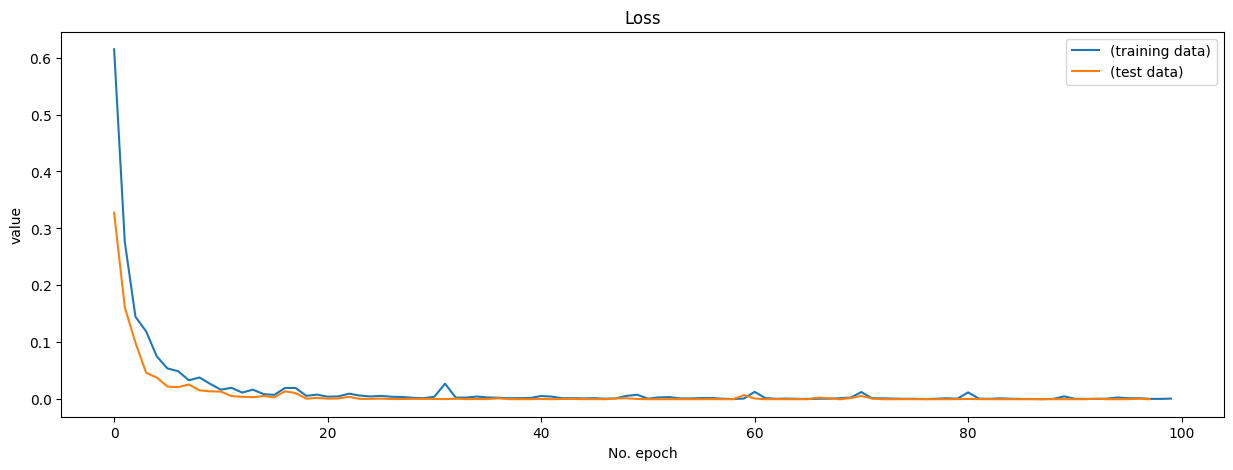

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot(hist.history['loss'], label='(training data)')
plt.plot(hist.history['val_loss'], label='(test data)')

plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.title('Loss')
plt.show()

♠ Model Evaluation - **Accuracy**


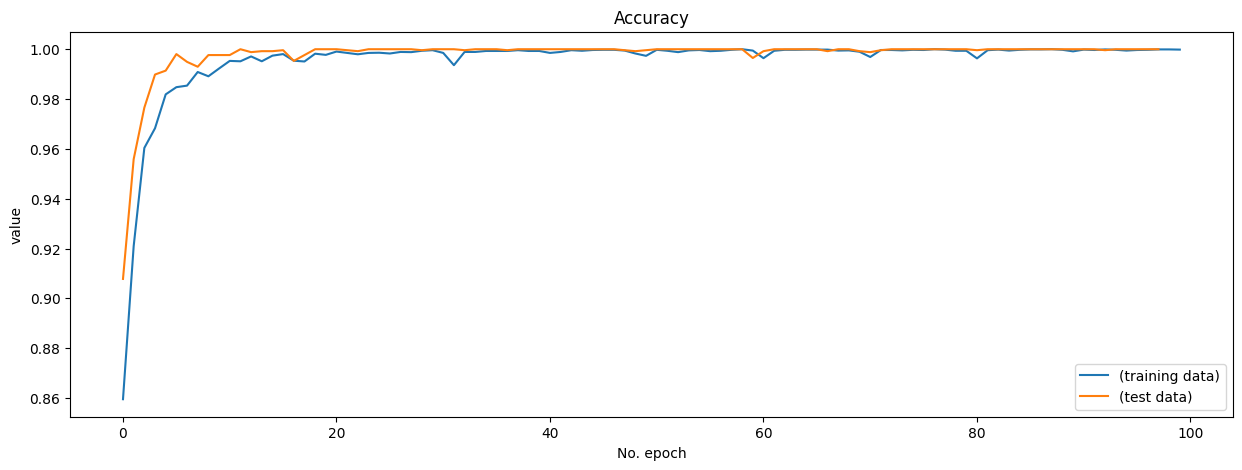

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot(hist.history['accuracy'], label='(training data)')
plt.plot(hist.history['val_accuracy'], label='(test data)')

plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.title('Accuracy')
plt.show()

♠ Prediction - **Prediction**

In [ ]:
res = (
  model.predict_generator(pred_gen(test), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

♠ Model Evaluation - **All metrics**


In [ ]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([get_image_FEN_label(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 1.00000%


In [ ]:
print("\nConfusion Matrix:\n------------------------")
confusion_matrix(test_fens, pred_fens)



Confusion Matrix:
------------------------


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [2]:
cm = confusion_matrix(test_fens, pred_fens)
# Define class labels
class_labels = ['test_fens', 'pred_fens']

# Create a heat map using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()

In [3]:
# # Create the heatmap
# plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')

# # Add a colorbar
# plt.colorbar()

# # Display the heatmap
# plt.show()

In [ ]:
print("Precison:", precision_score(test_fens, pred_fens, average='weighted'))
print("Recall:", recall_score(test_fens, pred_fens, average='weighted'))
print("F1 Score:", f1_score(test_fens, pred_fens, average='weighted'))
print("Accuracy:", accuracy_score(test_fens, pred_fens))

Precison: 0.99775
Recall: 0.99775
F1 Score: 0.99775
Accuracy: 0.99775


**6 - Preview Predictions and Outliers**

♠ Correct predictions


In [ ]:
import matplotlib.image as mpimg
def display_with_predicted_fen(image):
    plt.figure(figsize=(5,5))
    pred = model.predict(preprocess_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()
    return fen

2/2 [==============================] - 0s 6ms/step


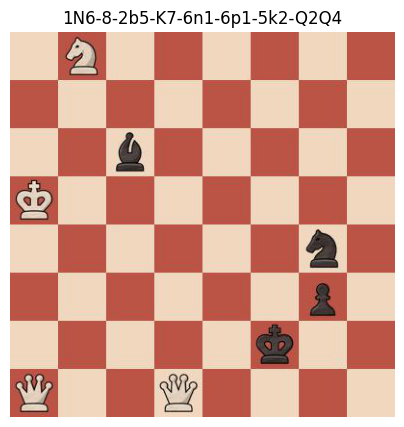

predicted FEN : 1N6-8-2b5-K7-6n1-6p1-5k2-Q2Q4


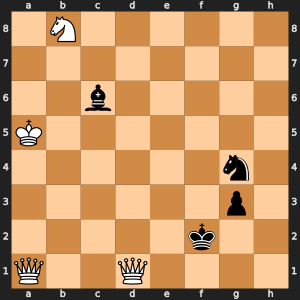

In [ ]:
predicted_fen=display_with_predicted_fen(test[230])
print("predicted FEN :",predicted_fen)
board = chess.Board(predicted_fen.replace('-', '/'))
svg_data=chess.svg.board(board, size=300) 
display(SVG(svg_data))

♠ Outliers ! - Not too many :)


In [ ]:
mask = (pred_fens != test_fens)
predicted_outliers=pred_fens[mask]
outliers=test_fens[mask]
print("how many outliers are there?",len(outliers))

how many outliers are there? 9


In [1]:
# if len(outliers)>0:
#     rand = np.random.randint(0, len(outliers))
#     predicted_fen=display_with_predicted_fen('../input/chess-positions/test/'+outliers[rand]+'.jpeg')
#     print("Actual FEN: "+outliers[rand])
#     print("predicted FEN :",predicted_fen)
#     board = chess.Board(predicted_fen.replace('-', '/'))
#     display(chess.svg.board(board, size=300))